In [2]:
import uproot
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from tqdm import tqdm
from scipy.optimize import curve_fit
import multiprocessing

In [3]:
file = uproot.open("histograms_ana_00473.root")

In [4]:
hit1X = file["TrackingMusr"]["musr"]["hit1X"].array()
hit1Y = file["TrackingMusr"]["musr"]["hit1Y"].array()
hit1Z = file["TrackingMusr"]["musr"]["hit1Z"].array()
tot1 = file["TrackingMusr"]["musr"]["seedTot1"].array()

hit2X = file["TrackingMusr"]["musr"]["hit2X"].array()
hit2Y = file["TrackingMusr"]["musr"]["hit2Y"].array()
hit2Z = file["TrackingMusr"]["musr"]["hit2Z"].array()
tot2 = file["TrackingMusr"]["musr"]["seedTot2"].array()

time_tracklet = file["TrackingMusr"]["musr"]["time_tracklet"].array()
hitpositionAtTargetX = file["TrackingMusr"]["musr"]["hitpositionAtTargetX"].array()
hitpositionAtTargetY = file["TrackingMusr"]["musr"]["hitpositionAtTargetY"].array()
hitpositionAtTargetZ = file["TrackingMusr"]["musr"]["hitpositionAtTargetZ"].array()

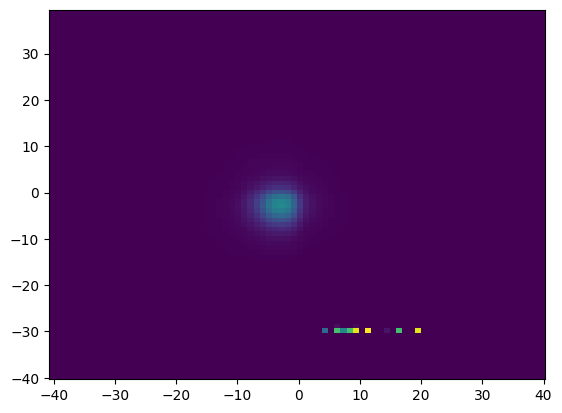

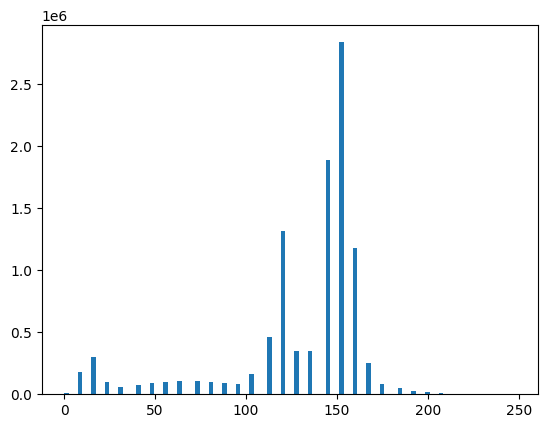

In [5]:
plt.hist2d(hitpositionAtTargetX, hitpositionAtTargetY, bins=80)
plt.show()
plt.hist(tot2, bins=100)
plt.show()

In [6]:
cutUpStream   = ((hit1Z ==  0) & (hit2Z == 20)) | ((hit1Z == 20) & (hit2Z ==  0))
cutDownStream = ((hit1Z == 40) & (hit2Z == 60)) | ((hit1Z == 60) & (hit2Z == 40))
cutMuonToT    = (tot1 > 150) & (tot2 > 150)
cutPosToT    = (tot1 <= 150) & (tot2 <= 150)
cutUpStreamMuon   = cutUpStream & cutMuonToT
cutUpStreamPos   = cutUpStream & cutPosToT

hitpositionAtTargetXUpStreamMuon = hitpositionAtTargetX[cutUpStreamMuon]
hitpositionAtTargetYUpStreamMuon = hitpositionAtTargetY[cutUpStreamMuon]
timeUpStreamMuon = time_tracklet[cutUpStreamMuon]

hitpositionAtTargetXUpStreamPos = hitpositionAtTargetX[cutUpStreamPos]
hitpositionAtTargetYUpStreamPos = hitpositionAtTargetY[cutUpStreamPos]
timeUpStreamPos = time_tracklet[cutUpStreamPos]

hitpositionAtTargetXDownStream = hitpositionAtTargetX[cutDownStream]
hitpositionAtTargetYDownStream = hitpositionAtTargetY[cutDownStream]
timeDownStream = time_tracklet[cutDownStream]

# poor alignment
hitpositionAtTargetXDownStream = hitpositionAtTargetXDownStream - 1
hitpositionAtTargetYDownStream = hitpositionAtTargetYDownStream - 1

print("#Up Muon", len(hitpositionAtTargetXUpStreamMuon), "#Up Pos", len(hitpositionAtTargetXUpStreamPos), "#Down", len(hitpositionAtTargetXDownStream))

#Up Muon 2947581 #Up Pos 1616431 #Down 2188846


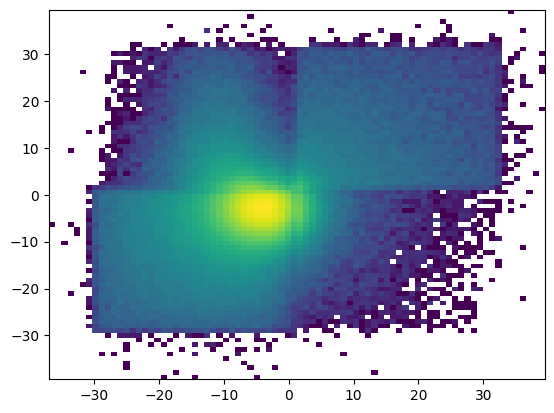

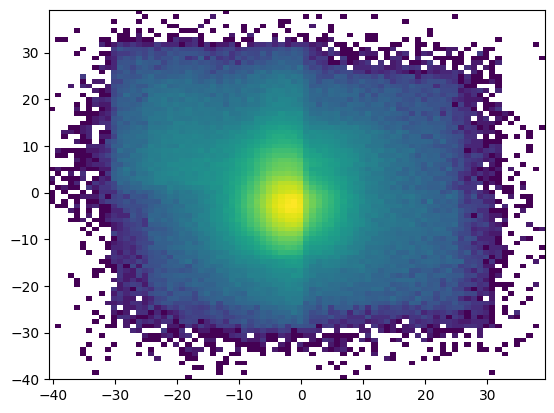

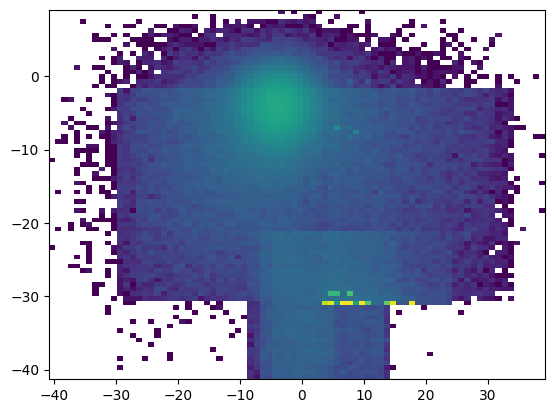

In [7]:
plt.hist2d(hitpositionAtTargetXUpStreamMuon, hitpositionAtTargetYUpStreamMuon, bins=80, norm=mpl.colors.LogNorm())
plt.show()
plt.hist2d(hitpositionAtTargetXUpStreamPos, hitpositionAtTargetYUpStreamPos, bins=80, norm=mpl.colors.LogNorm())
plt.show()
plt.hist2d(hitpositionAtTargetXDownStream, hitpositionAtTargetYDownStream, bins=80, norm=mpl.colors.LogNorm())
plt.show()

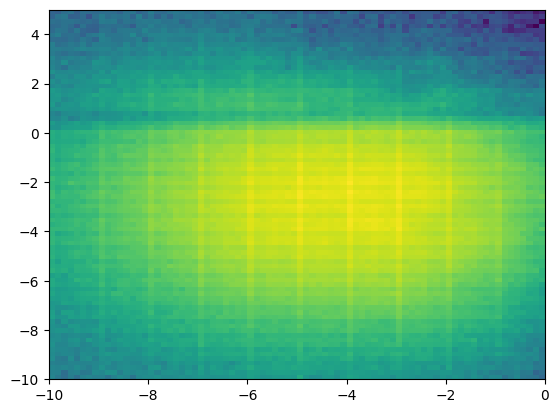

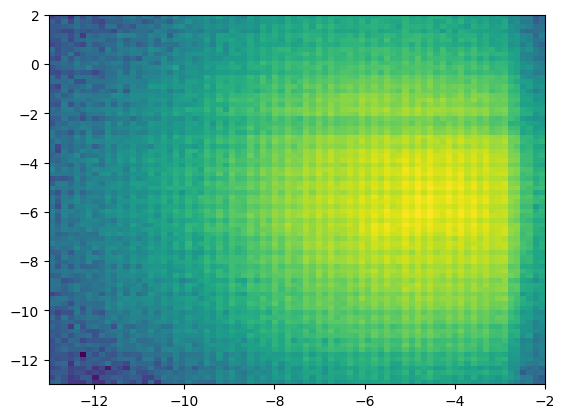

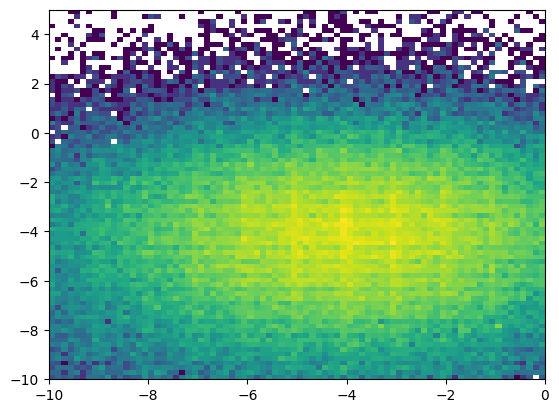

In [8]:
cutUp = (hitpositionAtTargetXUpStreamMuon < 0) & (hitpositionAtTargetXUpStreamMuon > -10) & (hitpositionAtTargetYUpStreamMuon < 5) & (hitpositionAtTargetYUpStreamMuon > -10)
cutDown = (hitpositionAtTargetXDownStream < 0) & (hitpositionAtTargetXDownStream > -10) & (hitpositionAtTargetYDownStream < 5) & (hitpositionAtTargetYDownStream > -10)
cutUpPos = (hitpositionAtTargetXUpStreamPos < 1) & (hitpositionAtTargetXUpStreamPos > -10) & (hitpositionAtTargetYUpStreamPos < 5) & (hitpositionAtTargetYUpStreamPos > -10)

plt.hist2d(hitpositionAtTargetXUpStreamMuon[cutUp], hitpositionAtTargetYUpStreamMuon[cutUp], bins=80, norm=mpl.colors.LogNorm())
plt.show()
plt.hist2d(hitpositionAtTargetXUpStreamPos[cutUpPos]-3, hitpositionAtTargetYUpStreamPos[cutUpPos]-3, bins=80, norm=mpl.colors.LogNorm())
plt.show()
plt.hist2d(hitpositionAtTargetXDownStream[cutDown], hitpositionAtTargetYDownStream[cutDown], bins=80, norm=mpl.colors.LogNorm())
plt.show()

In [9]:
XUp = hitpositionAtTargetXUpStreamMuon[cutUp]
YUp = hitpositionAtTargetYUpStreamMuon[cutUp]
TUp = timeUpStreamMuon[cutUp]

XDown = hitpositionAtTargetXDownStream[cutDown]
YDown = hitpositionAtTargetYDownStream[cutDown]
TDown = timeDownStream[cutDown]

In [10]:
sorted_idx_muon_up = sorted(range(len(TUp[:100000])), key=lambda k: TUp[:100000][k])
sorted_idx_pos_down = sorted(range(len(TDown[:100000])), key=lambda k: TDown[:100000][k])

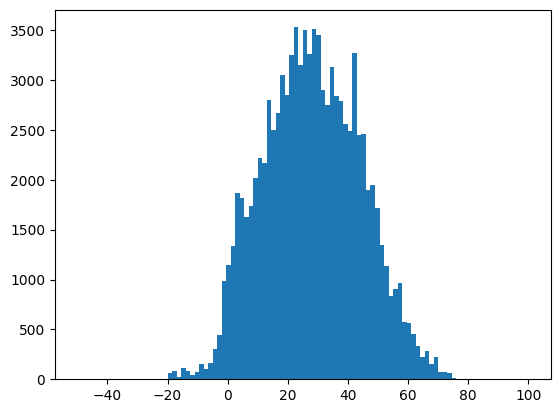

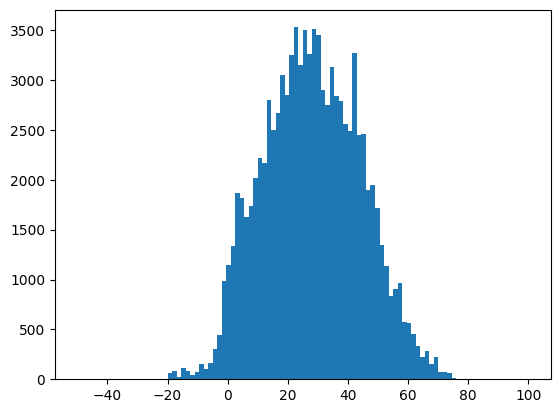

In [11]:
plt.hist(np.array(sorted(TDown[:100000]))*0.001 - np.array(sorted(TUp[:100000]))*0.001, bins=100, range=[-50, 100])
plt.show()
plt.hist(TDown[sorted_idx_pos_down]*0.001 - TUp[sorted_idx_muon_up]*0.001, bins=100, range=[-50, 100])
plt.show()

In [12]:
def loop(i):
    i_up = sorted_idx_muon_up[i]
    for j in range(i, i+2000, 1):
        if j == len(sorted_idx_pos_down): break
        i_down = sorted_idx_pos_down[j]
        down_x = XDown[i_down]
        down_y = YDown[i_down]
        down_t = TDown[i_down]
        up_x = XUp[i_up]
        up_y = YUp[i_up]
        up_t = TUp[i_up]
        if abs(up_t - down_t) > 80000: break 
        if abs(up_x - down_x) <= 2 and abs(up_y - down_y) <= 2:
            return [up_t, down_t, up_x, down_x, up_y, down_y]

with multiprocessing.Pool(8) as p:
    result = p.map(loop, range(len(sorted_idx_muon_up)))

# for i in tqdm():
#     i_up = sorted_idx_muon_up[i]
#     for j in range(i, i+2000, 1):
#         if j == len(sorted_idx_pos_down): break
#         i_down = sorted_idx_pos_down[j]
#         down_x = XDown[i_down]
#         down_y = YDown[i_down]
#         down_t = TDown[i_down]
#         up_x = XUp[i_up]
#         up_y = YUp[i_up]
#         up_t = TUp[i_up]
#         if abs(up_t - down_t) > 80000: break 
#         if abs(up_x - down_x) <= 2 and abs(up_y - down_y) <= 2:
#             time_up.append(up_t)
#             time_down.append(down_t)
#             x_down.append(down_x)
#             x_up.append(up_x)
#             y_down.append(down_y)
#             y_up.append(up_y)

In [16]:
time_up = []
time_down = []
for r in result:
    if r is None: continue
    if (r[1] * 0.001 - r[0] * 0.001) < 43: continue
    time_up.append(r[0])
    time_down.append(r[1])
#result_np = np.array(result)

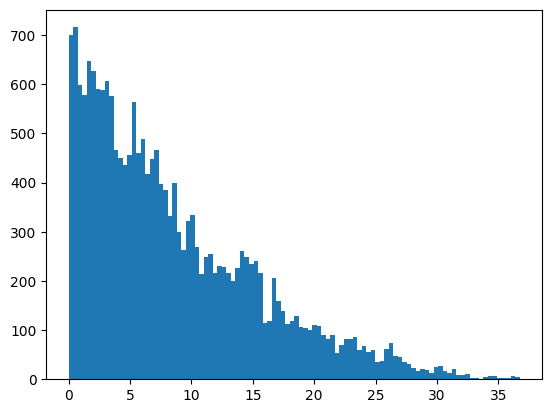

In [17]:
plt.hist(np.array(time_down)*0.001-43 - np.array(time_up)*0.001, bins=100)
plt.show()

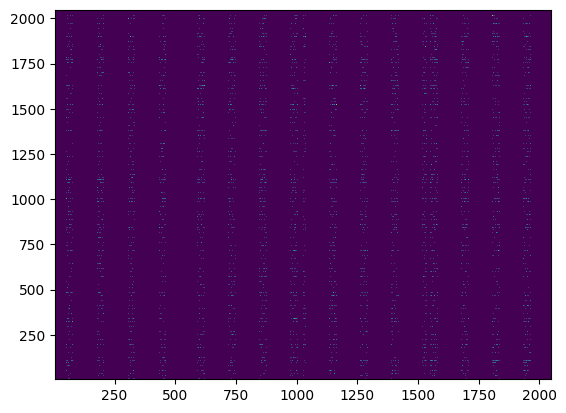

In [18]:
plt.hist2d(TDown[sorted_idx_pos_down]%2048, TUp[sorted_idx_muon_up]%2048, bins=2048)
plt.show()

[768.437463   -13.15149185 -59.38774221]


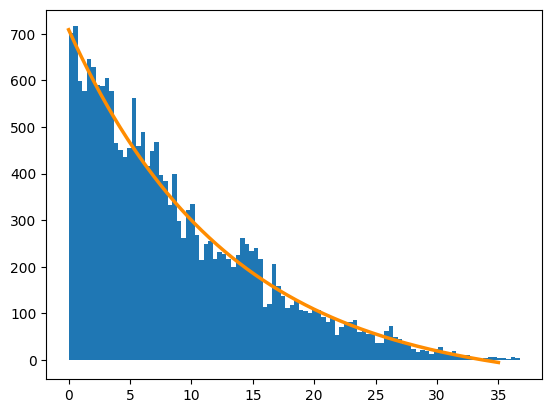

In [271]:
def fit_function(x, A, beta, B):
    return A * np.exp(x/beta) + B
data, bins = np.histogram(np.array(time_down)*0.001-43 - np.array(time_up)*0.001, bins=100)
popt, pcov = curve_fit(fit_function, xdata=bins[:-1], ydata=data, p0=[0, -0.4, 50])
print(popt)

xspace = np.linspace(0, 35, 1000)

plt.plot(xspace, fit_function(xspace, *popt), color='darkorange', linewidth=2.5, label=r'Fitted function')
plt.hist(np.array(time_down)*0.001-43 - np.array(time_up)*0.001, bins=100)
plt.show()